# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
import seaborn as sns
import pandas as pd

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [4]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/test_space/tasmin-qdc-adjustment-factors-additive-monthly_day_ACCESS-ESM1-5_historical-ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc"
qq_file = "/g/data/wp00/users/dbi599/test_space/tasmin-qdc-additive-monthly-infileq_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc"
example_lat = -42.9
example_lon = 147.3
example_month = 5
hist_units = "K"
ref_units = "K"
target_units = "C"
output_units = "C"
hist_var = "tasmin"
ref_var = "tasmin"
target_var = "tmin"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmin/gn/latest/tasmin_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmin/gn/latest/tasmin_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
ref_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmin/gn/latest/tasmin_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmin/gn/latest/tasmin_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc"
target_files = "/g/data/xv83/agcd-csiro/tmin/daily/tmin_AGCD-CSIRO_r005_19100101-20220405_daily_space-chunked.zarr"
hist_time_bounds = "1995-01-01 2014-12-31"
ref_time_bounds = "2035-01-01 2064-12-31"
target_time_bounds = "1990-01-01 2019-12-31"


In [5]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

In [6]:
point_selection = {'lat': example_lat, 'lon': example_lon}

## Read data

In [7]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [8]:
da_target = ds_target[target_var].sel(point_selection, method='nearest')
da_target = da_target.drop(['lat', 'lon'])
da_target = da_target.compute()

[########################################] | 100% Completed |  0.1s


In [9]:
da_target

<xarray.DataArray 'tmin' (time: 10957)>
array([14.251953 ,  8.171875 , 13.982422 , ..., 10.7265625, 12.9765625,
       11.176758 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:              2018-08-16 23:47:23 UTC
    analysis_version_number:    2.01
    cell_methods:               time: minimum
    frequency:                  daily
    length_scale_for_analysis:  250.0
    long_name:                  Daily minimum air temperature
    source:                     Interpolated surface observations
    standard_name:              air_temperature
    units:                      C

In [10]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)

In [11]:
da_hist = ds_hist[hist_var].sel(point_selection, method='nearest')
da_hist = da_hist.drop(['lat', 'lon'])
da_hist = da_hist.compute()

[########################################] | 100% Completed |  6.1s


In [12]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)

In [13]:
da_ref = ds_ref[ref_var].sel(point_selection, method='nearest')
da_ref = da_ref.drop(['lat', 'lon'])
da_ref = da_ref.compute()

[########################################] | 100% Completed |  8.9s


In [14]:
ds_adjust = xr.open_dataset(adjustment_file) 

## Perform QQ-scaling

In [15]:
#QM = sdba.EmpiricalQuantileMapping.train(
#    da_ref, da_hist, nquantiles=100, group="time.month", kind="+"
#)

# QM.ds['af'].plot()

In [16]:
ds_adjust = utils.regrid(ds_adjust, ds_target)

In [17]:
ds_adjust = ds_adjust.sel(point_selection, method='nearest')
ds_adjust = ds_adjust.drop(['lat', 'lon', 'ref_q', 'hist_clim', 'ref_clim'])
ds_adjust

<xarray.Dataset>
Dimensions:    (quantiles: 100, month: 12)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (quantiles, month) float32 1.237 0.9304 1.063 ... 0.6652 0.8523
    hist_q     (quantiles, month) float32 10.66 11.47 10.82 ... 16.65 17.99
Attributes:
    _xclim_adjustment:        {"py/object": "xclim.sdba.adjustment.EmpiricalQ...
    adj_params:               EmpiricalQuantileMapping(group=Grouper(add_dims...
    history:                  Fri Jan 13 16:31:08 2023: /g/data/xv83/dbi599/m...
    historical_period_start:  1995-01-01
    historical_period_end:    2014-12-31
    reference_period_start:   2035-01-01
    reference_period_end:     2064-12-31
    xclim_version:            0.36.0

In [18]:
def get_quantiles(da, quantiles, timescale='monthly'):
    """Get quantiles.
    Required because sdba.EmpiricalQuantileMapping.train only
    outputs hist_q and not others like ref_q.    
    """

    if timescale == 'monthly':
        months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        q_list = []
        for month in months:
            mth = sdba.nbutils.quantile(da[da['time'].dt.month == month], quantiles, ['time'])
            q_list.append(mth)
        da_q = xr.concat(q_list, dim='month')
        da_q.coords['month'] = months
        da_q = da_q.transpose('quantiles', 'month')
    elif timescale == 'annual':
        da_q = nbutils.quantile(da, quantiles, ['time'])
        #da_q = da_q.transpose('quantiles', 'lat', 'lon')
    else:
        raise ValueError('Invalid timescale: {timescale}')
        
    da_q.attrs['standard_name'] = 'Quantiles'
    da_q.attrs['long_name'] = 'Quantiles'

    return da_q

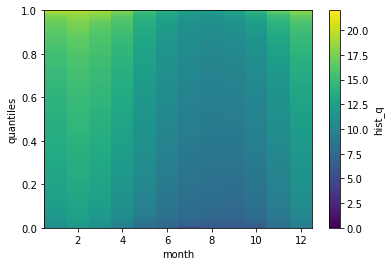

In [19]:
ds_adjust['hist_q'].plot(vmin=0, vmax=22, cmap='viridis')
plt.show()

In [20]:
target_q = get_quantiles(da_target, ds_adjust['quantiles'].values)

In [21]:
ds_adjust['hist_q'].values = target_q

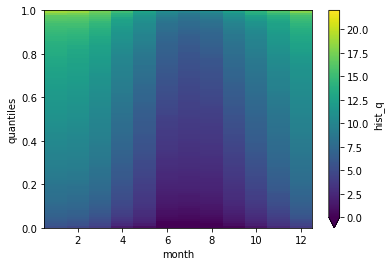

In [22]:
ds_adjust['hist_q'].plot(vmin=0, vmax=22, cmap='viridis')
plt.show()

In [23]:
qm = sdba.EmpiricalQuantileMapping.from_dataset(ds_adjust)

In [24]:
qm

EmpiricalQuantileMapping(group=Grouper(add_dims=[], name='time.month', window=1), kind='+')

In [25]:
da_qq_nearest = qm.adjust(da_target, extrapolation='constant', interp='nearest')
da_qq_linear = qm.adjust(da_target, extrapolation='constant', interp='linear')

## Check results

In [26]:
df_target = da_target.to_dataframe().reset_index()
df_target

,time,tmin
0,1990-01-01 09:00:00,14.251953
1,1990-01-02 09:00:00,8.171875
2,1990-01-03 09:00:00,13.982422
3,1990-01-04 09:00:00,9.332031
4,1990-01-05 09:00:00,6.551758
...,...,...
10952,2019-12-27 09:00:00,8.306641
10953,2019-12-28 09:00:00,12.636719
10954,2019-12-29 09:00:00,10.726562
10955,2019-12-30 09:00:00,12.976562


Using nearest interpolation means you can sort days and see which days got which adjustment factor...

In [27]:
df_qq_nearest = da_qq_nearest.to_dataframe().reset_index()

df_nearest = df_target.copy()
df_nearest = df_nearest.rename(columns={target_var: f'orig_{target_var}'})
df_nearest[f'new_{target_var}'] = df_qq_nearest['scen']
df_nearest['af'] = df_nearest[f'new_{target_var}'] - df_nearest[f'orig_{target_var}']
df_nearest['month'] = df_nearest['time'].dt.month.values

month_df_nearest = df_nearest[df_nearest['month'] == example_month].sort_values(f'orig_{target_var}', ascending=False)
month_df_nearest

,time,orig_tmin,new_tmin,af,month
5603,2005-05-05 09:00:00,14.577148,16.562572,1.985424,5
5602,2005-05-04 09:00:00,14.317383,16.302807,1.985424,5
4511,2002-05-09 09:00:00,13.126953,15.112377,1.985424,5
2678,1997-05-02 09:00:00,13.107422,15.092846,1.985424,5
6703,2008-05-09 09:00:00,12.697266,14.682690,1.985424,5
...,...,...,...,...,...
4160,2001-05-23 09:00:00,0.607422,0.671680,0.064258,5
1589,1994-05-09 09:00:00,0.306641,0.370899,0.064258,5
135,1990-05-16 09:00:00,-0.023438,0.040821,0.064258,5
7447,2010-05-23 09:00:00,-0.083008,-0.018750,0.064258,5


In [28]:
#month_df['af'] = month_df['af'].round(4)
#counts = month_df['af'].value_counts()
#counts

The same thing doesn't work for linear interpolation - all the adjustment factors are slightly different.

In [29]:
df_qq_linear = da_qq_linear.to_dataframe().reset_index()

df_linear = df_target.copy()
df_linear = df_linear.rename(columns={target_var: f'orig_{target_var}'})
df_linear[f'new_{target_var}'] = df_qq_linear['scen']
df_linear['af'] = df_linear[f'new_{target_var}'] - df_linear[f'orig_{target_var}']
df_linear['month'] = df_linear['time'].dt.month.values

month_df_linear = df_linear[df_linear['month'] == example_month].sort_values(f'orig_{target_var}', ascending=False)
month_df_linear

,time,orig_tmin,new_tmin,af,month
5603,2005-05-05 09:00:00,14.577148,16.381645,1.804497,5
5602,2005-05-04 09:00:00,14.317383,16.104649,1.787266,5
4511,2002-05-09 09:00:00,13.126953,15.000375,1.873422,5
2678,1997-05-02 09:00:00,13.107422,14.752027,1.644605,5
6703,2008-05-09 09:00:00,12.697266,14.521023,1.823757,5
...,...,...,...,...,...
4160,2001-05-23 09:00:00,0.607422,0.828640,0.221218,5
1589,1994-05-09 09:00:00,0.306641,0.446108,0.139467,5
135,1990-05-16 09:00:00,-0.023438,0.048950,0.072387,5
7447,2010-05-23 09:00:00,-0.083008,0.103187,0.186195,5


In [31]:
month_df_nearest[0:20]

,time,orig_tmin,new_tmin,af,month
5603,2005-05-05 09:00:00,14.577148,16.562572,1.985424,5
5602,2005-05-04 09:00:00,14.317383,16.302807,1.985424,5
4511,2002-05-09 09:00:00,13.126953,15.112377,1.985424,5
2678,1997-05-02 09:00:00,13.107422,15.092846,1.985424,5
6703,2008-05-09 09:00:00,12.697266,14.682690,1.985424,5
124,1990-05-05 09:00:00,12.527344,14.512768,1.985424,5
4897,2003-05-30 09:00:00,12.497070,14.482494,1.985424,5
1958,1995-05-13 09:00:00,12.447266,14.432690,1.985424,5
2680,1997-05-04 09:00:00,12.197266,13.770757,1.573491,5
8901,2014-05-16 09:00:00,12.147461,13.720952,1.573491,5


In [33]:
month_df_linear[0:20]

,time,orig_tmin,new_tmin,af,month
5603,2005-05-05 09:00:00,14.577148,16.381645,1.804497,5
5602,2005-05-04 09:00:00,14.317383,16.104649,1.787266,5
4511,2002-05-09 09:00:00,13.126953,15.000375,1.873422,5
2678,1997-05-02 09:00:00,13.107422,14.752027,1.644605,5
6703,2008-05-09 09:00:00,12.697266,14.521023,1.823757,5
124,1990-05-05 09:00:00,12.527344,14.219785,1.692441,5
4897,2003-05-30 09:00:00,12.497070,14.104733,1.607663,5
1958,1995-05-13 09:00:00,12.447266,14.297169,1.849903,5
2680,1997-05-04 09:00:00,12.197266,13.709564,1.512299,5
8901,2014-05-16 09:00:00,12.147461,13.872644,1.725183,5
